In [27]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.getOrCreate()
df = spark.read.csv('work/mushrooms.csv',header=True,inferSchema=True)
spark.conf.set('spark.sql.repl.eagerEval.enabled',True)


In [30]:
from pyspark.ml.feature import StringIndexer

In [31]:
ouput_col = []
for col in df.columns:
    ouput_col.append(f'{col}_indexed')
    

In [33]:
StringIndexers = StringIndexer(inputCols=df.columns, outputCols=ouput_col)

In [34]:
df = StringIndexers.fit(df).transform(df)

In [36]:
from pyspark.ml.classification import LogisticRegression, LinearSVC, DecisionTreeClassifier, DecisionTreeClassificationModel


In [37]:
df = df[[ouput_col]]

In [39]:
X, y = df[[ouput_col]].drop('class_indexed'), df['class_indexed']

In [40]:
from pyspark.ml.feature import VectorAssembler

In [41]:
va = VectorAssembler(inputCols=X.columns, outputCol='features')
df_train = va.transform(df)

In [42]:
df_train.count()

8124

In [43]:
train, test = df_train.randomSplit(weights=[10.0,2.0])
print(train.count())
test.count()

6742


1382

In [45]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, featuresCol="features", labelCol='class_indexed')

# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

# # We can also use the multinomial family for binary classification
# mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# # Fit the model
# mlrModel = mlr.fit(train)

# # Print the coefficients and intercepts for logistic regression with multinomial family
# print("Multinomial coefficients: " + str(mlrModel.coefficientMatrix))
# print("Multinomial intercepts: " + str(mlrModel.interceptVector))

Coefficients: (22,[7,18],[0.1914046408568066,0.1511918926264004])
Intercept: -0.23929037848760548


In [46]:
result = lrModel.evaluate(test)
result.accuracy

0.8791606367583212

In [47]:
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.mllib.stat import Statistics

In [48]:
columns = df.columns
vector_col = 'features'
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)


In [50]:
assembler = VectorAssembler(inputCols=ouput_col, outputCol='features')
mygraph_vector = assembler.transform(df)

In [51]:
matrix = Correlation.corr(mygraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

In [52]:
df_corr = spark.createDataFrame(corrmatrix, ouput_col)

In [54]:
!pip install dython
from dython.nominal import associations

In [55]:
df_pd =df.toPandas()

In [56]:
df_pd = df_pd.dropna(axis=1)

In [57]:
colcorr = []

In [58]:
for col in df_pd.columns:
    if "indexed" in col:
        colcorr.append(col)

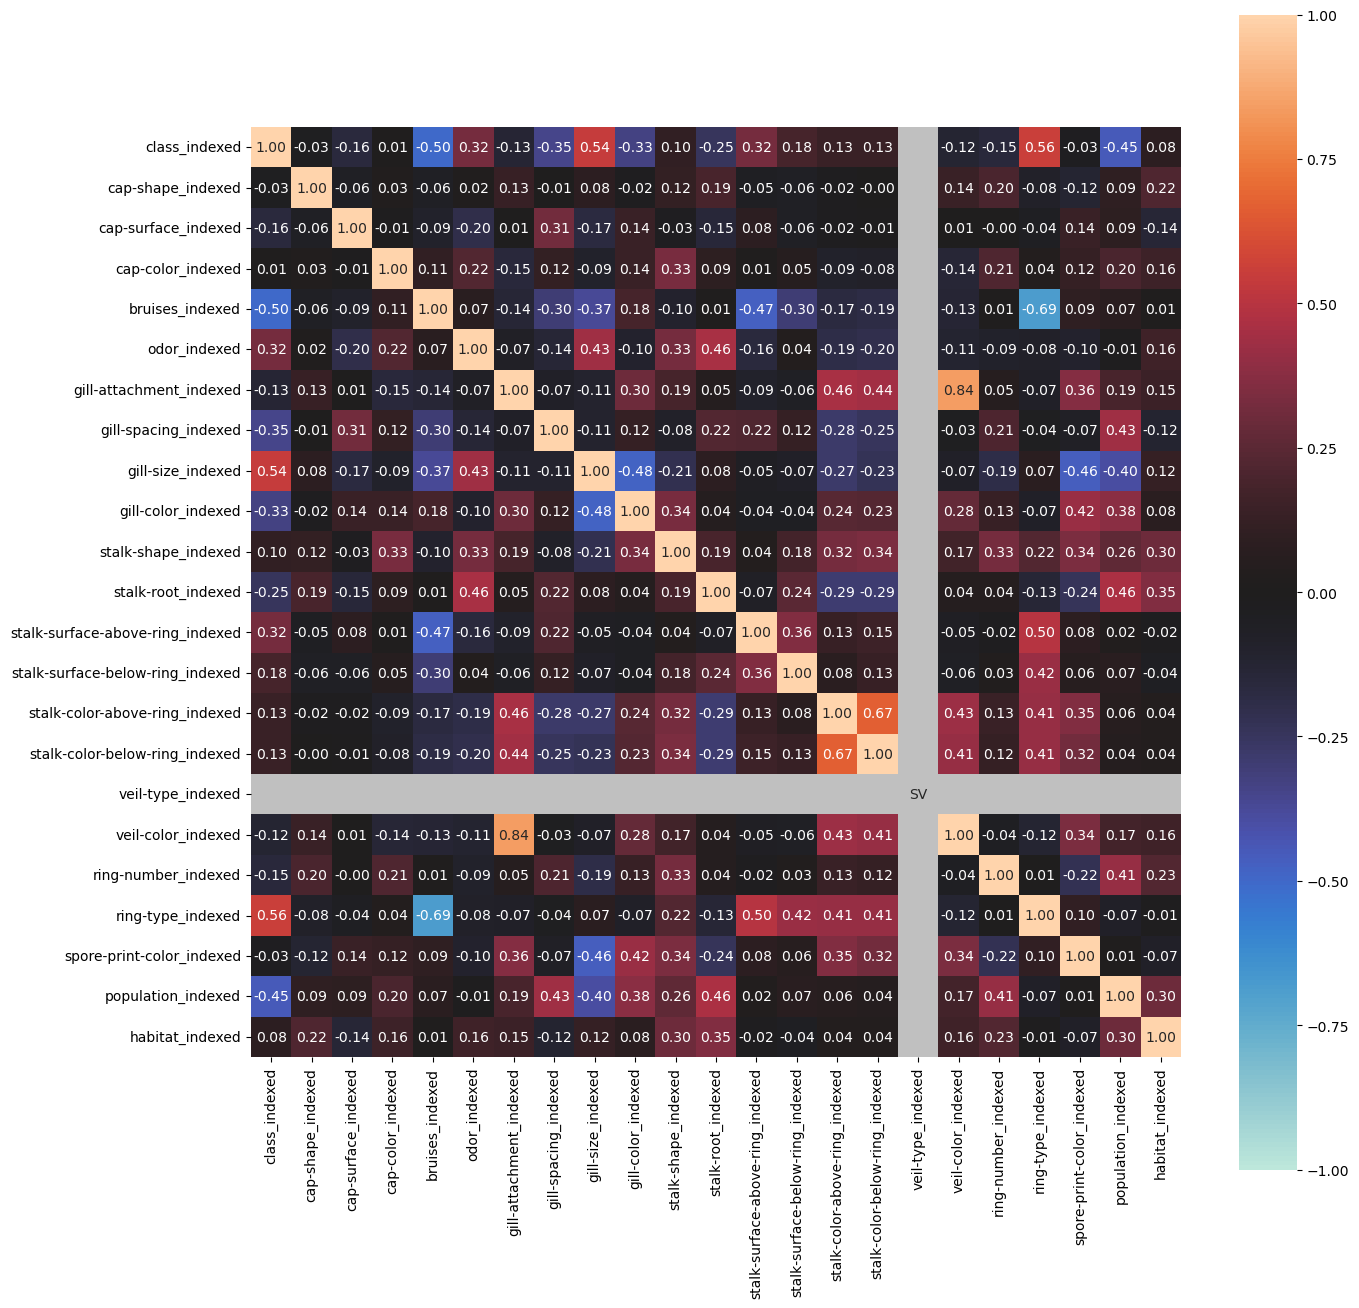

{'corr':                                   class_indexed  cap-shape_indexed  \
 class_indexed                          1.000000          -0.034451   
 cap-shape_indexed                     -0.034451           1.000000   
 cap-surface_indexed                   -0.159155          -0.058042   
 cap-color_indexed                      0.011735           0.029639   
 bruises_indexed                       -0.501530          -0.057287   
 odor_indexed                           0.323569           0.017134   
 gill-attachment_indexed               -0.129200           0.126426   
 gill-spacing_indexed                  -0.348387          -0.005866   
 gill-size_indexed                      0.540024           0.083962   
 gill-color_indexed                    -0.334999          -0.016882   
 stalk-shape_indexed                    0.102019           0.116854   
 stalk-root_indexed                    -0.248390           0.190482   
 stalk-surface-above-ring_indexed       0.323350          -0.045912  

In [60]:
associations(df_pd[colcorr], figsize=(15, 15))

In [62]:
dt = DecisionTreeClassifier(featuresCol='features', labelCol= "class_indexed")

In [66]:
model = dt.fit(train)
prediction = model.transform(test)
prediction.select('prediction',"class_indexed", "features").show(5)

+----------+-------------+--------------------+
|prediction|class_indexed|            features|
+----------+-------------+--------------------+
|       0.0|          0.0|(22,[6,7,8,9,12,1...|
|       0.0|          0.0|(22,[3,8,19,20],[...|
|       0.0|          0.0|(22,[3,8,19],[1.0...|
|       0.0|          0.0|(22,[3,8,14,19,20...|
|       0.0|          0.0|(22,[3,8,13,14,19...|
+----------+-------------+--------------------+
only showing top 5 rows



In [67]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [69]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="class_indexed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction)
print("Test Error = %g " % (1.0 - accuracy))

Test Error = 0.00289436 
